In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
import os
import asyncio
import aiohttp
import math
from typing import Literal, List, Dict, Any
from typing_extensions import TypedDict
from dotenv import load_dotenv

# LangGraph and LangChain imports
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0
)

In [6]:
llm.invoke("Hi, how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BtA0rcvtOJmJw1PVvU2R2ViAHOh5R', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--be1011b9-026a-47e3-987d-2379a5c0df3f-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
# Create async HTTP session (global for reuse)
async_session = None

async def get_async_session():
    """Get or create the global async HTTP session."""
    global async_session
    if async_session is None:
        async_session = aiohttp.ClientSession()
    return async_session

async def close_async_session():
    """Close the global async HTTP session."""
    global async_session
    if async_session:
        await async_session.close()
        async_session = None

In [10]:
async def get_geocode_locationiq_async(place: str) -> tuple:
    """Async version of geocode function."""
    session = await get_async_session()
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": os.getenv("GEOLOCATION_IQ_API_KEY"),
        "q": place,
        "format": "json"
    }
    
    try:
        async with session.get(url, params=params) as response:
            data = await response.json()
            if data:
                return float(data[0]["lat"]), float(data[0]["lon"])
            return None, None
    except Exception:
        return None, None

In [12]:
@tool
async def geocode_locationiq_async(place: str) -> dict:
    """
    Geocode a human-readable place name into geographic coordinates using LocationIQ API.
    
    This tool takes a location name (e.g., "Park Street, Kolkata" or "USF, Tampa") 
    and returns geospatial metadata including its bounding box, latitude, longitude, 
    display name, and location type.

    Parameters:
        place (str): The name of the location to geocode.

    Returns:
        dict: A dictionary containing the following keys:
            - 'boundingbox': List of [min_lat, max_lat, min_lng, max_lng]
            - 'lat': Latitude of the place (float)
            - 'lon': Longitude of the place (float)
            - 'display_name': Full formatted address (str)
            - 'type': Type of place (e.g., 'university', 'neighbourhood')
            
        If geocoding fails, a dictionary with an 'error' key is returned.
    """
    
    session = await get_async_session()
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": os.getenv("GEOLOCATION_IQ_API_KEY"),
        "q": place,
        "format": "json"
    }

    try:
        async with session.get(url, params=params) as response:
            data = await response.json()
            
            if not data:
                return {"error": f"No result found for place: {place}"}

            first_result = data[0]
            return {
                "boundingbox": first_result.get("boundingbox"),
                "lat": float(first_result.get("lat")),
                "lon": float(first_result.get("lon")),
                "display_name": first_result.get("display_name"),
                "type": first_result.get("type")
            }

    except Exception as e:
        return {"error": str(e)}

In [13]:
async def get_places_async(city: str, query: str = "attractions") -> list:
    """
    Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of places to search for (e.g., 'attractions', 'museums')

    Returns:
        list: A list of dictionaries, each containing:
            - name: Place name
            - categories: List of category names
            - address: Formatted address
            - phone: Telephone number if available
            - website: Website URL if available
    """
    
    api_key = os.getenv("FOURSQUARE_API_KEY")
    
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]

    session = await get_async_session()
    url = "https://places-api.foursquare.com/places/search"
    headers = {
        "accept": "application/json",
        "X-Places-Api-Version": "2025-06-17",
        "authorization": api_key
    }
    params = {
        "near": city,
        "query": query,
        "limit": 10
    }

    try:
        async with session.get(url, headers=headers, params=params) as response:
            if response.status != 200:
                return [{"error": f"Foursquare API error: {await response.text()}"}]

            data = await response.json()
            results = data.get("results", [])
            if not results:
                return [{"message": f"No results found for '{query}' in {city}."}]

            # Create tasks for geocoding addresses concurrently
            geocode_tasks = []
            extracted = []
            
            for place in results:
                name = place.get("name", "Unknown")
                categories = [cat.get("name") for cat in place.get("categories", [])]
                address = place['location']['formatted_address']
                phone = place.get("tel", None)
                website = place.get("website", None)
                
                # Create geocoding task
                geocode_task = get_geocode_locationiq_async(address)
                geocode_tasks.append(geocode_task)
                
                extracted.append({
                    "name": name,
                    "categories": categories,
                    "address": address,
                    "phone": phone,
                    "website": website
                })

            # Execute all geocoding tasks concurrently
            geocode_results = await asyncio.gather(*geocode_tasks)
            
            # Add geocoding results to extracted data
            for i, (lat, lon) in enumerate(geocode_results):
                extracted[i]["latitude"] = lat
                extracted[i]["longitude"] = lon

            return extracted

    except Exception as e:
        return [{"error": str(e)}]

In [14]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points on Earth."""
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

@tool
async def get_hotels_by_area_and_radius_async(
    bbox: str,
    arrival_date: str,
    departure_date: str,
    star_rating: str = "3,4,5",
    room_qty: int = 1,
    guest_qty: int = 1,
    children_qty: int = 0,
    children_age: str = "",
    currency: str = "USD",
    order_by: str = "popularity",
    categories_filter: str = "class::1,class::2,class::3",
    language: str = "en-us",
    travel_purpose: str = "leisure",
    offset: int = 0
) -> list:
    """
    Fetch hotel listings within a bounding box and return only key fields, sorted by distance to bbox center.

    Parameters:
        - bbox (str): Bounding box in format "min_lat,max_lat,min_lng,max_lng"
        - star_rating (str): Comma-separated star classes to filter, e.g., "3,4,5"
        - arrival_date (str): Check-in date (YYYY-MM-DD)
        - departure_date (str): Check-out date (YYYY-MM-DD)
        - room_qty (int): Number of rooms
        - guest_qty (int): Number of adults
        - children_qty (int): Number of children
        - children_age (str): Comma-separated list of children ages
        - currency (str): Price currency (e.g., USD, INR)
        - order_by (str): API sort preference (not used post-filter)
        - categories_filter (str): Used internally, overridden by star_rating
        - language (str): Response language
        - travel_purpose (str): "leisure" or "business"
        - offset (int): Pagination offset

    Returns:
        - list of hotel dicts sorted by ascending distance from bbox center.
    """
    # Convert star_rating to API-compatible format
    categories_filter = ",".join([f"class::{s.strip()}" for s in star_rating.split(",")])

    # Compute bbox center
    try:
        min_lat, max_lat, min_lng, max_lng = map(float, bbox.split(","))
        center_lat = (min_lat + max_lat) / 2
        center_lng = (min_lng + max_lng) / 2
    except Exception as e:
        return [{"error": f"Invalid bbox format: {e}"}]

    session = await get_async_session()
    url = "https://apidojo-booking-v1.p.rapidapi.com/properties/list-by-map"
    querystring = {
        "room_qty": str(room_qty),
        "guest_qty": str(guest_qty),
        "bbox": bbox,
        "search_id": "none",
        "children_age": children_age,
        "price_filter_currencycode": currency,
        "categories_filter": categories_filter,
        "languagecode": language,
        "travel_purpose": travel_purpose,
        "children_qty": str(children_qty),
        "order_by": order_by,
        "offset": str(offset),
        "arrival_date": arrival_date,
        "departure_date": departure_date
    }
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_HOTELS"),
        "x-rapidapi-host": "apidojo-booking-v1.p.rapidapi.com"
    }

    try:
        async with session.get(url, headers=headers, params=querystring) as response:
            if response.status != 200:
                return [{"error": await response.text()}]

            data = await response.json()
            results = data.get("result", [])
            hotels = []

            for item in results:
                if not item.get("class"):
                    continue

                lat = item.get("latitude")
                lng = item.get("longitude")
                if lat is None or lng is None:
                    continue

                distance_km = haversine_distance(center_lat, center_lng, lat, lng)

                hotels.append({
                    "name": item.get("hotel_name"),
                    "star_rating": item.get("class"),
                    "review_score": item.get("review_score"),
                    "review_word": item.get("review_score_word"),
                    "review_count": item.get("review_nr"),
                    "address": item.get("address"),
                    "city": item.get("city"),
                    "district": item.get("district"),
                    "latitude": lat,
                    "longitude": lng,
                    "price_per_night": item.get("min_total_price") or (
                        item.get("price_breakdown", {}).get("all_inclusive_price")
                    ),
                    "currency": item.get("currencycode", "INR"),
                    "image": item.get("main_photo_url"),
                    "booking_url": item.get("url"),
                    "is_free_cancellable": item.get("is_free_cancellable"),
                    "is_mobile_deal": item.get("is_mobile_deal"),
                    "checkin_from": item.get("checkin", {}).get("from"),
                    "checkout_until": item.get("checkout", {}).get("until"),
                    "distance_km": round(distance_km, 2)
                })

            # Sort by distance from bbox center
            hotels.sort(key=lambda h: h["distance_km"])
            return hotels

    except Exception as e:
        return [{"error": str(e)}]

In [15]:
@tool
async def convert_currency_async(amount: float, to_currency: str, base: str = "USD") -> float:
    """
    Convert a monetary amount from one currency to another using real-time exchange rates.

    This function fetches the latest exchange rate between the specified base currency
    and the target currency using the ExchangeRate-API and calculates the converted value.

    Args:
        amount (float): The amount of money to convert.
        to_currency (str): The target currency code (e.g., "EUR", "INR").
        base (str, optional): The source currency code. Defaults to "USD".

    Returns:
        float: The converted amount in the target currency, rounded to two decimal places.
                If the exchange rate is unavailable, returns a dictionary with an error message.

    Example:
        >>> convert_currency(100, "INR")
        8356.25

    Notes:
        - This tool uses the open endpoint from https://open.er-api.com.
        - Ensure that `to_currency` and `base` are valid ISO currency codes.
    """
    
    session = await get_async_session()
    url = f"https://open.er-api.com/v6/latest/{base}"
    
    try:
        async with session.get(url) as response:
            data = await response.json()
            rate = data["rates"].get(to_currency)
            if not rate:
                return {"error": f"Rate unavailable for {to_currency}"}
            return round(amount * rate, 2)
    except Exception as e:
        return {"error": str(e)}

In [16]:
async def get_weather_async(city: str) -> dict:
    """
    Get detailed current weather data for a city as a dictionary.
    """
    
    api_key = os.getenv("OPENWEATHER_API_KEY")
    session = await get_async_session()
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    
    try:
        async with session.get(url) as response:
            if response.status != 200:
                return {"error": f"Failed to get weather: {await response.text()}"}

            data = await response.json()
            
            # Get coordinates concurrently
            lat, lon = await get_geocode_locationiq_async(city)

            return {
                "city": data.get("name"),
                "country": data.get("sys", {}).get("country"),
                "description": data.get("weather", [{}])[0].get("description"),
                "temperature_celsius": data.get("main", {}).get("temp"),
                "feels_like_celsius": data.get("main", {}).get("feels_like"),
                "temp_min": data.get("main", {}).get("temp_min"),
                "temp_max": data.get("main", {}).get("temp_max"),
                "humidity": data.get("main", {}).get("humidity"),
                "pressure": data.get("main", {}).get("pressure"),
                "wind_speed_mps": data.get("wind", {}).get("speed"),
                "wind_deg": data.get("wind", {}).get("deg"),
                "visibility_m": data.get("visibility"),
                "cloud_coverage_percent": data.get("clouds", {}).get("all"),
                "sunrise_utc": data.get("sys", {}).get("sunrise"),
                "sunset_utc": data.get("sys", {}).get("sunset"),
                "icon": data.get("weather", [{}])[0].get("icon"),
                "latitude": lat,
                "longitude": lon,
            }
    except Exception as e:
        return {"error": str(e)}

In [17]:
async def get_flight_fares_async(from_code: str, to_code: str, date: str, adult: int = 1, type_: str = "economy") -> list:
    """
    Fetches flight fare data using the Flight Fare Search API on RapidAPI.

    Args:
        from_code (str): IATA code of departure airport (e.g., 'BLR')
        to_code (str): IATA code of arrival airport (e.g., 'CCU')
        date (str): Travel date in YYYY-MM-DD
        adult (int): Number of adult passengers (default: 1)
        type_ (str): Cabin class (default: 'economy')

    Returns:
        list: List of flights with key details: timing, pricing, stops, countries, and cabin info.
    """
    session = await get_async_session()
    url = "https://flight-fare-search.p.rapidapi.com/v2/flights/"

    querystring = {
        "from": from_code,
        "to": to_code,
        "date": date,
        "adult": str(adult),
        "type": type_,
        "currency": "USD"
    }

    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_FLIGHTS"),
        "x-rapidapi-host": "flight-fare-search.p.rapidapi.com"
    }

    try:
        async with session.get(url, headers=headers, params=querystring) as response:
            raw = await response.json()
            flights = raw.get("results", [])
            
            if not isinstance(flights, list) or not flights:
                return [{"message": "No flights found."}]

            results = []
            for f in flights:
                stop_info = []
                stop_summary = f.get("stopSummary", {})

                # Extract intermediate stops if present
                if isinstance(stop_summary, dict):
                    for key, val in stop_summary.items():
                        if key != "connectingTime" and isinstance(val, dict):
                            stop_info.append({
                                "intermediate_airport": val.get("airport", "Unknown"),
                                "stop_duration_minutes": val.get("stopDuration")
                            })

                results.append({
                    "flight_code": f.get("flight_code"),
                    "airline": f.get("flight_name"),
                    "cabin_type": f.get("cabinType", "Unknown"),
                    "stops": f.get("stops", "Unknown"),
                    "departure_city": f.get("departureAirport", {}).get("city"),
                    "departure_country": f.get("departureAirport", {}).get("country", {}).get("label"),
                    "departure_time": f.get("departureAirport", {}).get("time"),
                    "arrival_city": f.get("arrivalAirport", {}).get("city"),
                    "arrival_country": f.get("arrivalAirport", {}).get("country", {}).get("label"),
                    "arrival_time": f.get("arrivalAirport", {}).get("time"),
                    "duration": f.get("duration", {}).get("text"),
                    "price": f.get("totals", {}).get("total"),
                    "currency": f.get("totals", {}).get("currency"),
                    "intermediate_stops": stop_info if stop_info else None
                })

            return results

    except Exception as e:
        return [{"error": str(e)}]

In [18]:
# State definitions
class Router(TypedDict):
    next: Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", "geolocation_expert", 'FINISH']

class State(MessagesState):
    next: str

In [19]:
# Initialize search tool
search_tool = TavilySearch()

In [20]:
async def supervisor(state: State) -> Command[Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", "geolocation_expert", "__end__"]]:
    """
    The supervisor routes tasks to the appropriate expert based on the user message context.
    It uses an LLM with structured output to decide which agent to call next.
    """
    
    system_prompt = f"""
    You are a Supervisor Agent in charge of managing a travel planning conversation between the following expert agents:
    {', '.join(['hotel_search_expert', 'weather_expert', 'place_search_expert', 'flight_fares_search_expert', 'geolocation_expert'])}.

    Each expert has a unique specialization:
    - hotel_search_expert → Retrieves real-time hotel listings using a bounding box, arrival/departure dates, and optional filters (star rating, etc.).
    - weather_expert → Provides real-time weather information for a specific city.
    - place_search_expert → Finds attractions, activities, or restaurants within a city.
    - flight_fares_search_expert → Searches for flights and pricing between two IATA airport codes on a given date.
    - geolocation_expert → Converts user-provided place names into coordinates and bounding boxes (~5km radius) for use in location-based tools.

    YOUR TASK:
    Based on the user's request and current conversation state:
    1. Decide which agent(s) to invoke next.
    2. Ensure dependencies are resolved first (e.g., fetch `bbox` before hotel query).
    3. Avoid parallel steps unless they are truly independent.
    4. After all relevant agents have completed their tasks, reply with **"FINISH"**.

    IMPORTANT COORDINATE RULE:
    Whenever the user request involves a **location, city, hotel, attraction, or point of interest**, ensure the final response includes:
    - **Latitude (`lat`)**
    - **Longitude (`lon`)**
    of that place, **either in the main description or as part of structured output**.
    This applies to hotels, restaurants, trekking spots, cities, etc.

    RESPONSE FORMAT:
    Return ONE of the following:
    - The **agent name** to execute next (e.g., `hotel_search_expert`)
    - A **brief reason** why this agent is needed now
    - Tool **input hints or parameters** if needed
    - Or `"FINISH"` if all tasks are done and user goal is fulfilled

    TIPS:
    - For hotel queries, **always run `geolocation_expert` first** to obtain a bbox.
    - Chain tools when necessary (e.g., bbox → hotels).
    - Ensure city names, IATA codes, and dates are passed correctly.
    - Be sequential, complete, and never hallucinate tool outputs or inputs.
    - Use your judgment to decompose multi-part user goals (e.g., weather + hotels + flights).
    - Never delegate outside an agent's skillset.

    User Request:
    """

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    llm_with_structure_output = llm.with_structured_output(Router)
    
    # Use ainvoke for async operation
    response = await llm_with_structure_output.ainvoke(messages)
    
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [21]:
async def hotel_search_agent(state: State) -> Command[Literal["supervisor"]]:
    """
    The hotel expert uses the hotel-related tools to find hotels based on location, star rating, and dates.
    """
    agent = create_react_agent(
        llm,
        tools=[get_hotels_by_area_and_radius_async, geocode_locationiq_async],
        prompt="""
        You are a hotel search expert. Always geocode the location before calling the hotel API if bbox is not provided.

        Return a list of hotels with the following fields for each hotel:
        - name
        - star_rating
        - review_score
        - review_word
        - review_count
        - address
        - city
        - district
        - latitude
        - longitude
        - price_per_night
        - currency
        - image
        - booking_url
        - is_free_cancellable
        - is_mobile_deal
        - checkin_from
        - checkout_until
        - distance_km

        Always include `latitude` and `longitude` for each hotel. Return results in plain JSON-like text format.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="hotel_search_expert")
            ]
        },
        goto="supervisor",
    )

In [22]:
async def weather_agent(state: State) -> Command[Literal["supervisor"]]:
    """Async weather agent."""
    agent = create_react_agent(
        llm,
        tools=[get_weather_async],
        prompt="""
        You are a weather expert. Use the tool to fetch current weather for the user's city.

        Return the following weather information:
        - city
        - country
        - description
        - temperature_celsius
        - feels_like_celsius
        - temp_min
        - temp_max
        - humidity
        - pressure
        - wind_speed_mps
        - wind_deg
        - visibility_m
        - cloud_coverage_percent
        - sunrise_utc
        - sunset_utc
        - icon
        - latitude
        - longitude

        Always include `latitude` and `longitude` for the weather location. Return structured JSON-like plain text.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="weather_expert")]},
        goto="supervisor"
    )

In [23]:
async def place_search_agent(state: State) -> Command[Literal["supervisor"]]:
    """Async place search agent."""
    agent = create_react_agent(
        llm,
        tools=[get_places_async],
        prompt="""
        You are an expert in finding attractions, restaurants, and cultural places.

        Use the get_places tool and return a list of top 5 suggestions. For each place, return:
        - name
        - categories
        - address
        - latitude
        - longitude
        - phone
        - website

        `Latitude` and `longitude` must always be included. Return results in plain structured JSON-style output.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="place_search_expert")]},
        goto="supervisor"
    )

In [24]:
async def flight_fares_search_agent(state: State) -> Command[Literal["supervisor"]]:
    """Async flight search agent."""
    agent = create_react_agent(
        llm,
        tools=[get_flight_fares_async],
        prompt="You are a flight search expert. Use the flight API to return fares, stops, airlines, and prices based on user input."
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="flight_fares_search_expert")]},
        goto="supervisor"
    )

In [25]:
async def geolocation_agent(state: State) -> Command[Literal["supervisor"]]:
    """Async geolocation agent."""
    agent = create_react_agent(
        llm,
        tools=[geocode_locationiq_async],
        prompt="You are a geolocation expert. Your job is to convert place names into geographic coordinates and bounding boxes."
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="geolocation_expert")]},
        goto="supervisor"
    )

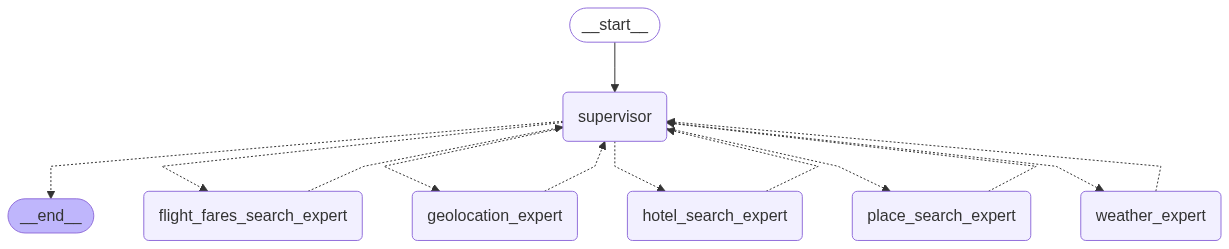

In [26]:
def build_async_graph():
    """Build and return the async graph."""
    graph = StateGraph(State)

    # Add nodes
    graph.add_node("supervisor", supervisor)
    graph.add_node("hotel_search_expert", hotel_search_agent)
    graph.add_node("weather_expert", weather_agent)
    graph.add_node("place_search_expert", place_search_agent)
    graph.add_node("flight_fares_search_expert", flight_fares_search_agent)
    graph.add_node("geolocation_expert", geolocation_agent)

    # Add edges
    graph.add_edge(START, "supervisor")
    graph.add_edge("hotel_search_expert", "supervisor")
    graph.add_edge("weather_expert", "supervisor")
    graph.add_edge("place_search_expert", "supervisor")
    graph.add_edge("flight_fares_search_expert", "supervisor")
    graph.add_edge("geolocation_expert", "supervisor")

    return graph.compile()

app = build_async_graph()
app

In [31]:
async def main():
    """Main async function to run the multi-agent system."""
    app = build_async_graph()
    
    print("Testing the async multi-agent system...")
    print("=" * 50)
    
    # Test case 1: Hotel search
    async for event in app.astream(
        {
            "messages": [("user", """
                I'm planning a short trip to South Goa next weekend. Can you show me a few 4-star or 5-star hotels around that area for check-in on July 15 and check-out on July 17, 2025?
                I prefer free cancellation options if available.
            """)]
        },
        stream_mode="values"
    ):
        event["messages"][-1].pretty_print()


await main()

Testing the async multi-agent system...
================================ Human Message =================================


                I'm planning a short trip to South Goa next weekend. Can you show me a few 4-star or 5-star hotels around that area for check-in on July 15 and check-out on July 17, 2025?
                I prefer free cancellation options if available.
            
================================ Human Message =================================


                I'm planning a short trip to South Goa next weekend. Can you show me a few 4-star or 5-star hotels around that area for check-in on July 15 and check-out on July 17, 2025?
                I prefer free cancellation options if available.
            
================================ Human Message =================================
Name: geolocation_expert

I found a hotel in South Goa, but I need to search for more options specifically for 4-star and 5-star hotels with free cancellation. Unfortunately, I cann

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


================================ Human Message =================================
Name: hotel_search_expert

Here are some 4-star and 5-star hotels in South Goa for your stay from July 15 to July 17, 2025, with options for free cancellation where available:

```json
[
    {
        "name": "The Rose Goa Beach Resort",
        "star_rating": 4.0,
        "review_score": 8.8,
        "review_word": "Excellent",
        "review_count": 167,
        "address": "Near St Anne's Church",
        "city": "Agonda",
        "district": "",
        "latitude": 15.042283,
        "longitude": 73.987718,
        "price_per_night": 14548.77,
        "currency": "INR",
        "image": "https://cf.bstatic.com/xdata/images/hotel/square60/612731999.jpg?k=a8dfe6a610273dd8e4b6501a1a897fc53c1cd6495f8f01da3f559fefb1911012&o=",
        "booking_url": "https://www.booking.com/hotel/in/the-rose-goa-beach-resort.html",
        "is_free_cancellable": true,
        "is_mobile_deal": false,
        "checkin_from":

In [30]:
async def main():
    """Main async function to run the multi-agent system."""
    app = build_async_graph()
    
    print("Testing the async multi-agent system...")
    print("=" * 50)
    
    # Test case 1: Hotel search
    async for event in app.astream(
        {
            "messages": [("user", "suggest some trekking places near chennai")]
        },
        stream_mode="values"
    ):
        event["messages"][-1].pretty_print()


await main()

Testing the async multi-agent system...
================================ Human Message =================================

suggest some trekking places near chennai
================================ Human Message =================================

suggest some trekking places near chennai
================================ Human Message =================================
Name: geolocation_expert

Here are some popular trekking places near Chennai:

1. **Yelagiri Hills**: Located about 230 km from Chennai, Yelagiri offers several trekking trails with beautiful views and a pleasant climate.

2. **Kudremukh**: Although a bit farther away (around 350 km), Kudremukh is known for its lush green hills and challenging treks.

3. **Nandi Hills**: Approximately 300 km from Chennai, Nandi Hills is a popular spot for trekking and offers stunning sunrise views.

4. **Sivaganga Hill**: Located near the town of Kodaikanal, this hill offers a moderate trek with scenic views.

5. **Panchamalai Hills**: Abou

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


================================ Human Message =================================
Name: geolocation_expert

Here are the geographic coordinates and bounding boxes for some popular trekking places near Chennai:

1. **Yelagiri Hills**
   - **Coordinates**: Latitude 12.03639, Longitude 78.080992
   - **Bounding Box**: [12.01639, 12.05639, 78.060992, 78.100992]
   - **Location**: Yelagiri, Dharmapuri, Tamil Nadu, India

2. **Kolli Hills**
   - **Coordinates**: Latitude 11.322125849999999, Longitude 78.39351174329565
   - **Bounding Box**: [11.188085, 11.4542849, 78.2766866, 78.4897292]
   - **Location**: Kolli Hills, Namakkal, Tamil Nadu, India

3. **Nandi Hills**
   - **Coordinates**: Latitude 13.5221981, Longitude 77.67901086591104
   - **Bounding Box**: [13.3492494, 13.694217, 77.5869471, 77.7505204]
   - **Location**: Nandi Hills State Forest, Chikkaballapura, Karnataka, India

4. **Panchamalai Hills**
   - **Coordinates**: Latitude 11.052213, Longitude 78.408526
   - **Bounding Box**: 